# Exploring the One Standard Error rule WIP 

### The following notebook is inspired by chapter 3 of The Elements of Statistical Learning. Using the prostate cancer dataset I recreate the regression analysis in that chapter, comparing OLS, Ridge, Lasso and Partial Least Squares estimators and the application of the 'one standard error' rule to determine a more parsimonious model fit. 

In [242]:
import pandas as pd
import numpy as np
from scipy.stats import t
from matplotlib import pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error


#### Simple utility functions to process the data. The original training and test sets are indicated by the 'train' column. For this analysis I keep the test set held out until the end.

In [243]:
def data_proc(data_loc:str):
    '''Returns training and test sets as well as a list containing feature names'''
    
    cols = pd.read_csv("../data/ISLR_ESLR/prostate.csv", nrows=0)
    data = pd.read_csv("../data/ISLR_ESLR/prostate.csv", usecols = [i for i in cols if i != 'id'])
    
    target = 'lpsa'
    features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
    
    X, y = data[features].values, data[target].values
    train_idx = data.train=="T"
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[~train_idx], y[~train_idx]
    
    
    
    return X_train, y_train, X_test, y_test, features

def standardiser(X):
    '''Returns a standardised matrix for a given input X'''
    mu = np.mean(X, axis=0)
    sd = np.std(X, axis=0)
    return (X-mu)/sd


In [244]:
X_train, y_train, X_test, y_test, features = data_proc(r"C:\Users\matth\Documents\python\ISLR_ESLR\prostate.csv")

In [245]:
X_train = standardiser(X_train)
X_test = standardiser(X_test)

### OLS
#### To make this bit more interesting I create my own OLS class.

In [246]:
class OLS:
    '''Performs ordinary least squares regression for a given input matrix X and dependent variably vector y
    
    This class can return a prediction vector, coefficient of determination, mean squared error and 
    a summary of coefficients, standard errors, t values and p-values
    '''
    def __init__(self, feature_labels=None, mean_regression=False):
        self.features = feature_labels
        self.mean_reg = mean_regression
        if mean_regression:
            self.features = 'mean'
            self.mean_reg = True
        
    def fit(self, X,y):
        if self.mean_reg:
            X = np.ones((X.shape[0],1))
        else:
            X = np.hstack((np.ones((X.shape[0],1)),X))
        coefs = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T, y))
        self.coefs = np.round(coefs,3)
        self.intercept = coefs[0]
        self.m = X.shape[0]
        self.n = len(coefs)
        self.mse = self._mse(X,y, coefs)
        self.coef_se = np.round(self._coef_se(X),3)
        self.t_values = np.round(self._t_values(),3)
        self.p_values = np.round(self._p_values(),3)
        self.r_squared = self.__r_squared(y)
    
    def _mse(self, X, y, coefs):
        self.y_pred = np.dot(X,coefs) 
        return np.sum((y-self.y_pred)**2)/(self.m-self.n)
    
    def predict(self,X):
        if not self.mean_reg:
            return np.dot(X,self.coefs[1:]) + self.intercept
        else:
            return self.coefs
        
    def _coef_se(self,X):
        var = self.mse*np.diag(np.linalg.inv(np.dot(X.T,X)))
        return np.sqrt(var)

    def _t_values(self):
        return self.coefs/self.coef_se
    
    def _p_values(self):
        return [(1-t.cdf(abs(i), df=self.m-self.n))*2 for i in self.t_values]
    
    def __r_squared(self,y):
        self.df = self.m - self.n
        y_mu = np.mean(y)
        return 1 - (np.sum((y-self.y_pred)**2/(self.df))/np.sum((y-y_mu)**2/(self.df)))
    
    def summary(self):
        output = zip(['intercept']+list(ols.features),list(ols.coefs),list(ols.coef_se),
                     list(ols.t_values),list(ols.p_values))
        print('variable            coef          se      tstat   pvalue')
        print('--------------------------------------------------------')
        for variable, coef, se, tstat, pvalue in output:
            print(f'{variable:>10}{coef:>14.2f}{se:>13.2f}{tstat:>10.2f}{pvalue:>9.2f}')


In [247]:
ols = OLS(feature_labels=features)
ols.fit(X_train, y_train)
ols.summary()

variable            coef          se      tstat   pvalue
--------------------------------------------------------
 intercept          2.45         0.09     28.18     0.00
    lcavol          0.71         0.13      5.35     0.00
   lweight          0.29         0.11      2.74     0.01
       age         -0.14         0.10     -1.40     0.17
      lbph          0.21         0.10      2.06     0.04
       svi          0.31         0.12      2.48     0.02
       lcp         -0.29         0.15     -1.86     0.07
   gleason         -0.02         0.14     -0.15     0.88
     pgg45          0.28         0.16      1.74     0.09


#### In order to validate the outputs I compare my outputs with the results of Statsmodels OLS class, happily they check out.

In [248]:
import statsmodels.api as sm

statsmodels_ols = sm.OLS(y_train, sm.add_constant(X_train)).fit()
statsmodels_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           2.04e-12
Time:                        18:03:37   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4523      0.087     28.182      0.000       2.278       2.627
x1             0.7110      0.133      5.366      0.000       0.446       0.976
x2             0.2905      0.106      2.751      0.008       0.079       0.502
x3            -0.1415      0.101     -1.396      0.168      -0.344       0.061
x4             0.2104      0.102      2.056      0.044       0.006       0.415
x5             0.3073      0.124      2.469      0.017       0.058       0.556
x6            -0.2868      0.154     -1.867      0.067      -0.594       0.021
x7            -0.0208      0.142     -0.147      0.884      -0.304       0.263
x8             0.2753      0.158      1.738      0.088      -0.042       0.592
==============================================================================
Omnibus:                        0.825   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.389
Skew:                          -0.164   Prob(JB):                        0.823
Kurtosis:                       3.178   Cond. No.                         4.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [249]:
print("Model R Squared: {0}".format(ols.r_squared))
print("Model MSE: {0}".format(ols.mse))

Model R Squared: 0.6943711796768237
Model MSE: 0.5073514562053173


#### The MSE on the entire training set is likely to be biased downward (overly optimistic) therefore I deploy k-fold cross validation (with k=10) and average the mean squared error across the folds. As expected this yields a higher error.

In [250]:
def mse(y, y_pred):
    return np.sum((y-y_pred)**2)/len(y)



def KFold_CV(x,y, features = None ,fold=10, kwargs_kfold={}, kwargs_ols={}):
    
    folds = KFold(n_splits = fold, **kwargs_kfold)
    
    average_error = []    
    
    
    for train_idx, val_idx in folds.split(x, y):
        x_t, x_v = x[train_idx,:], x[val_idx,:]
        y_t, y_v = y[train_idx], y[val_idx]
        lr = OLS(**kwargs_ols)    
        lr.fit(x_t, y_t)
        y_hat = lr.predict(x_v)
        average_error.append(mse(y_v,y_hat))
        
    return average_error


In [251]:
ols_cv_error = np.mean(KFold_CV(X_train, y_train, features, kwargs_kfold={'shuffle':True}))
ols_cv_error

0.5966283813018667

In [252]:
ols_coefficients = ols.coefs

#### Here I estimate a baseline model using my OLS class. This returns the mean of y_train since I am regressing y on a vector of 1's. Whilst not readily clear from the book, this model enters into all of the charts for the ridge, lasso and PLS cross-validation curves as the null model (i.e. the model with zero degrees of freedom, shrinkage and components.   

In [253]:
baseline_model = OLS(mean_regression=True)
baseline_model.fit(X_train, y_train)
baseline_model.predict(X_train)


array([2.452])

#### The following helper functions enable me to perform k-fold cross validation over a grid of a parameters, identify a parsimonious model within one standard error of the optimal model (which minimises the validation error), plot the error curve and then choose the final optimal model to be estimated on the training data.

In [254]:
def cross_validate(X, y, model, param_hash, n_folds, **kwargs):
    '''Performs k-fold cross validation over a grid of parameters, returning the average error per hyperparameter
    and it's respective standard error, the model index for the best validation errorminimiser, the model within
    one standard error of this optimial model and it's associated parameter grid'''
    
    #set the number of folds for cross validation 
    folds = KFold(n_splits = n_folds, shuffle=True)
    #create a container for the optimal parameters
    optimal_grid = {}
    
    #Use grid search to evaluate the cross validation errors across hyperparameters
    gs = GridSearchCV(model, param_hash, cv=folds, scoring = 'neg_mean_squared_error',
                      return_train_score=True, **kwargs)
    gs.fit(X,y)
    
    #stack up the cross validation errors and take the mean and standard error across folds
    cv_errors = -np.vstack([gs.cv_results_[f'split{i}_test_score'] for i in range(n_folds)]).T
    mean_errors = np.mean(cv_errors, axis=1)
    std_errors =  np.std(cv_errors,  axis=1)/np.sqrt(n_folds)
    
    #find the best model with the lowest error
    best_idx = np.argmin(mean_errors)
    min_error = mean_errors[best_idx]
    min_error_sd =  std_errors[best_idx]
    
    #find the model within one standard error of the best model
    one_sd_error = min_error+min_error_sd
    one_sd_model_idx = np.argmax(mean_errors < one_sd_error)
    
    #record the parameters for the one standard error model
    one_sd_model_params = list(param_hash.values())[0][one_sd_model_idx] 
    optimal_grid[list(param_hash.keys())[0]] = one_sd_model_params
    
    return mean_errors, std_errors, best_idx, one_sd_model_idx, optimal_grid

def cv_plot(mean_errors, std_errors, param_space, one_sd_model_idx,title, xlab):
    '''Plots the cross validation erros, standard error bars and identifies the one standard error model'''
    fig, ax = plt.subplots(figsize=(6,6))
    #we need to add zero to the parameter space in order to accomodate the baseline model in the plot
    param_space = [0] + param_space
    
    #stack the baseline model mean and standard errors
    mean_errors_stacked = np.hstack((baseline_mean_error, mean_errors))
    std_errors_stacked = np.hstack((baseline_std_errors, std_errors))
    
    #plot the curve, add the error bars and tidy up
    ax.plot(param_space, mean_errors_stacked, c= 'red', linewidth=0.5)
    ax.errorbar(param_space,mean_errors_stacked, c='red', linestyle='None', marker='o',
                elinewidth=0.5, markersize=2, yerr=std_errors_stacked, ecolor='green', capsize=3)
    ax.axvline(x=param_space[one_sd_model_idx], c='black', linewidth=0.5, linestyle='--')
    ax.set_xlabel(xlab)
    ax.set_ylabel('Cross Val Error')
    ax.set_title(title)
    
def set_one_sd_model(model, params):
    '''Defines a model based on a given set of parameters, i.e. the one stand error parameters 
    from the cross_validate function'''
    _model = model
    _model.set_params(**params)
    return _model




#### Compute the mean cross validation error and standard errors for the baseline model 

In [255]:
#TO DO: get this to work with my OLS class
from sklearn.dummy import DummyRegressor
base_grid = {'constant':[None]}
baseline_mean_error, baseline_std_errors, *_ = cross_validate(X_train, y_train, DummyRegressor(), base_grid, 10)

### Ridge Regression
#### The one standard error model has 4 degrees of freedom corresponding to alpha = 44.

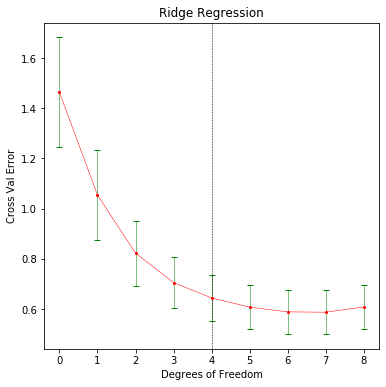

In [428]:
#Params have been choosen to approximate the different model degrees of freedom on p.62
#TO DO, add code used to compute this
ridge_params = {'alpha':[436, 157, 78, 44, 24, 12, 4, 0.00001]}

ridge_mean_error, ridge_std_errors, ridge_best_idx, \
ridge_one_sd_idx, ridge_opt_params = cross_validate(X_train, y_train, Ridge(), ridge_params, 10)

cv_plot(ridge_mean_error, ridge_std_errors, param_space=list(range(1,9)), 
        one_sd_model_idx = ridge_one_sd_idx+1,title='Ridge Regression', xlab='Degrees of Freedom')

In [257]:
ridge_one_sd = set_one_sd_model(Ridge(),ridge_opt_params).fit(X_train, y_train)
ridge_one_sd_coeffs = np.hstack((one_sd_ridge.intercept_,one_sd_ridge.coef_))

### Lasso Regression
#### Optimal shrinkage factor is approximately 0.5, corresponding to alpha = 0.1

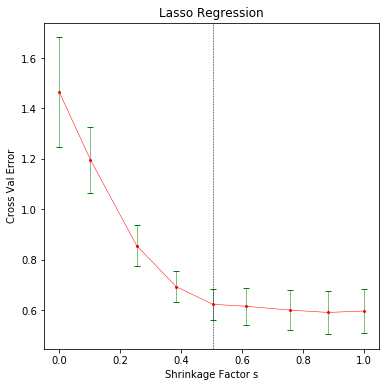

In [357]:
lasso_params = {'alpha':[0.680, 0.380, 0.209, 0.100, 0.044, 0.027, 0.012, 0.001]}

lasso_mean_error, lasso_std_errors, lasso_best_idx, \
lasso_one_sd_idx, lasso_opt_params = cross_validate(X_train, y_train, Lasso(), lasso_params, 10)

cv_plot(lasso_mean_error, lasso_std_errors, param_space=[0.102, 0.254, 0.384, 0.504, 0.612, 0.756, 0.883, 1],
        one_sd_model_idx = lasso_one_sd_idx+1,title='Lasso Regression', xlab='Shrinkage Factor s')



In [356]:
lasso_one_sd 

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [259]:

lasso_one_sd = set_one_sd_model(Lasso(), lasso_opt_params).fit(X_train, y_train)
lasso_one_sd_coeffs = np.hstack((lasso_one_sd.intercept_, lasso_one_sd.coef_))


#### Plotting Lasso coefficient profiles 

In [379]:

def plot_coefficient_profiles(alphas, model, model_type, X, y, title, x_title, y_title):
    coefficient_grid = np.vstack([model(alpha=alpha).fit(X,y).coef_
                                  for alpha in reversed(alphas)])
    if model_type.lower() == 'lasso':
        norm = np.sum(np.abs(coefficient_grid), axis=1)
    elif model_type.lower() == 'ridge':
        norm = np.sum(np.square(coefficient_grid), axis=1)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(norm, coefficient_grid, color='teal', ls="--")
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    plt.setp(ax2, yticks = coefficient_grid[-1],yticklabels=features)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)
    

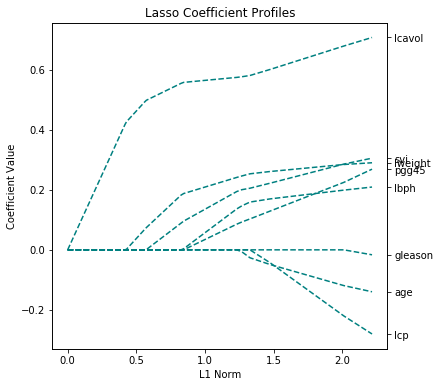

In [380]:
alphas = np.linspace(0.001, 0.93, 100)
plot_coefficient_profiles(alphas, model=Lasso, model_type='lasso', X=X_train, y = y_train, 
                          title='Lasso Coefficient Profiles', x_title='L1 Norm', y_title ='Coefficient Value')

### Partial Least Squares Regression

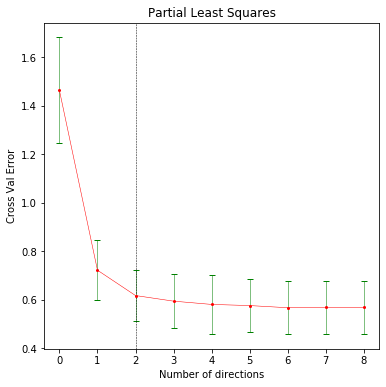

In [260]:
pls_params = {'n_components': list(range(1,9))}

pls_mean_error, pls_std_errors, pls_best_idx, \
pls_one_sd_idx, pls_opt_params = cross_validate(X_train, y_train, PLSRegression(scale=False), pls_params, 10)

cv_plot(pls_mean_error, pls_std_errors, param_space=list(range(1,9)),
        one_sd_model_idx = pls_one_sd_idx+1,title='Partial Least Squares', xlab='Number of directions')



In [348]:
pls_one_sd = set_one_sd_model(PLSRegression(), pls_opt_params).fit(X_train, y_train)
pls_one_sd_coeffs = np.vstack((pls_one_sd.y_mean_,pls_one_sd.coef_))

In [398]:
pls_yhat = pls_one_sd.predict(X_test)
mean_squared_error(y_test, pls_yhat)
np.sqrt(mse(y_test, pls_yhat))

7.582010719847645

### Bringing it together, summarising differences in coefficients and evaluating the test set error

#### TO DO - add commentary 

In [330]:
#TO DO - tidy up table
def model_summary(*args, names):
    container = [np.array(np.round(i,2)) for i in args]
    _features = ['intercept']+features
    names = ['features']+names
    results = pd.DataFrame((_features, *container)).T
    results.columns = names
    
    return results
    

In [332]:
model_summary(ols_coefficients, ridge_one_sd_coeffs, lasso_one_sd_coeffs, 
              pls_one_sd_coeffs, names=['ols','ridge','lasso','pls'])

,features,ols,ridge,lasso,pls
0,intercept,2.45,2.45,2.45,[2.45]
1,lcavol,0.71,0.41,0.57,[0.44]
2,lweight,0.29,0.25,0.23,[0.36]
3,age,-0.14,-0.04,-0,[-0.02]
4,lbph,0.21,0.16,0.11,[0.24]
5,svi,0.31,0.23,0.17,[0.26]
6,lcp,-0.29,0.02,0,[0.09]
7,gleason,-0.02,0.04,0,[0.01]
8,pgg45,0.28,0.13,0.07,[0.08]


In [426]:
def evaluate_test_error(*args, model_names):
    error = []
    std_error = []
    names = ['error']+list(model_names)
    error_labs = ['test error', 'std_error']
    for model in args:
        y_pred = model.predict(X_test)
        error.append(mean_squared_error(y_test, y_pred))
        std_error.append(mean_squared_error(y_test, y_pred)/np.sqrt(len(y_test)))
    results = pd.DataFrame((np.round(error,2), np.round(std_error,2)))
    results = pd.concat([pd.Series(error_labs), results], axis=1)
    results.columns=names
    
    return results

In [427]:
evaluate_test_error(ols, ridge_one_sd, lasso_one_sd, pls_one_sd, model_names=['ols', 'ridge', 'lasso', 'pls'])

,error,ols,ridge,lasso,pls
0,test error,0.55,0.51,0.46,0.61
1,std_error,0.10,0.09,0.08,0.11
